In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd

# Linear regression

## Task 1

In [2]:
def load_csv(filepath):
    df = pd.read_csv(filepath)
    df.insert(loc=0, column='x0', value=np.ones(len(df)))
    return df.loc[:, df.columns != 'y'].values, df['y'].values

def mse(y, y_pred):
    return np.mean((y_pred - y)**2)

def linear_regression(X, y):
    return np.linalg.pinv(X.T.dot(X)).dot(X.T).dot(y)

## Task 2

In [3]:
X_train, y_train = load_csv('dataset/regression/train_2d_reg_data.csv')
X_test, y_test = load_csv('dataset/regression/test_2d_reg_data.csv')
w_train = linear_regression(X_train, y_train)
training_error = mse(X_train.dot(w_train), y_train)
test_error = mse(X_test.dot(w_train), y_test)

print("w0: " + str(w_train[0]) + "\tw1: " + str(w_train[1]) + "\tw2: " + str(w_train[2]))
print("\nMean Squared Error (MSE)")
print("MSE_training: " + str(training_error) + "\tMSE_test: " + str(test_error))

w0: 0.24079270870924657	w1: 0.4815568550719211	w2: 0.05864390258297314

Mean Squared Error (MSE)
MSE_training: 0.010386850731462317	MSE_test: 0.009529764450619004


As we can see, the model generalizes quite well. The MSE for the training- and the test data are relatively equal. Hence, there is no clear signs of neither over- nor underfitting.

## Task 3

w0: 0.19558660470155004	w1: 0.6128879513156789

Mean Squared Error (MSE)
MSE_training: 0.013758791126537117	MSE_test: 0.012143754475727526


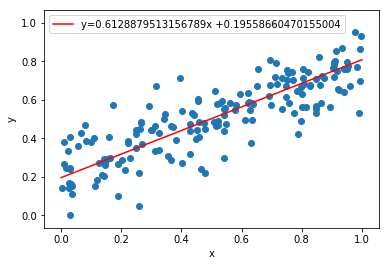

In [4]:
X_train, y_train = load_csv('dataset/regression/train_1d_reg_data.csv')
X_test, y_test = load_csv('dataset/regression/test_1d_reg_data.csv')
w_train = linear_regression(X_train, y_train)
w_test = linear_regression(X_test, y_test)
training_error = mse(X_train.dot(w_train), y_train)
test_error = mse(X_test.dot(w_test), y_test)

print("w0: " + str(w_train[0]) + "\tw1: " + str(w_train[1]))
print("\nMean Squared Error (MSE)")
print("MSE_training: " + str(training_error) + "\tMSE_test: " + str(test_error))

x_point = X_test[:, -1]
y_point = y_test
x_axes = np.linspace(0,1,100)
line = w_train[1]*x_axes + w_train[0]
plt.scatter(x_point, y_point)
plt.plot(x_axes, line, '-r', label= 'y=' + str(w_train[1]) + "x +" + str(w_train[0]))
plt.legend(loc='upper left')
plt.xlabel("x")
plt.ylabel("y")
plt.show()

The line seem to fit the datapoints relatively well. As we can see from the scatterplot, the data contains a fair bit of variance. Some error could have been remedied by adding some dimensions to the training data, but this might result in overfitting.

# Logistic regression

In [5]:
def load_csv(filepath):
    df = pd.read_csv(filepath)
    df.columns = ['x1', 'x2', 'y']
    df['x0'] = df['x1'].pow(0)
    df['x1^2'] = df['x1'].pow(2)
    df['x2^2'] = df['x2'].pow(2)
    return df

def sigmoid(z):
    return float(1.0 / float((1.0 + math.exp(-1.0 * z))))

def split_data(data, feature_names):
    return data[feature_names].values, data['y'].values

def hypothesis(weights, x):
    z = 0
    for i in range(len(weights)):
        z += x[i] * weights[i]
    return sigmoid(z)

def cross_entropy_error(X, Y, weights):
    sum_errors = 0
    for i in range(len(Y)):
        if Y[i] == 1:
            error = Y[i] * math.log(hypothesis(weights, X[i]))
        else:
            error = (1 - Y[i]) * math.log(1 - hypothesis(weights, X[i]))
        sum_errors += error
    return - 1 / len(Y) * sum_errors

def cross_entropy_derivative(X, Y, weights, j):
    sum_errors = 0
    for i in range(len(Y)):
        sum_errors += (hypothesis(weights, X[i]) - Y[i]) * X[i][j]
    return sum_errors

def update_rule(X, Y, weights, alpha):
    new_weights = []
    error = cross_entropy_error(X, Y, weights)
    for j in range(len(weights)):
        new_weights_value = weights[j] - float(alpha) / float(len(Y)) * cross_entropy_derivative(X, Y, weights, j)
        new_weights.append(new_weights_value)
    return new_weights, error

def logistic_regression(X, Y, alpha, weights, iter):
    cross_entropy_series = []
    for x in range(iter):
        new_weights, error = update_rule(X, Y, weights, alpha)
        weights = new_weights
        cross_entropy_series.append(error)
    return weights, cross_entropy_series

def train(path_train_data, initial_weights, feature_name, alpha, iterations):
    df_train = load_csv(path_train_data)
    X_train, y_train = split_data(df_train, feature_name)
    return logistic_regression(X_train, y_train, alpha, initial_weights, iterations)

def test(path_test_data, trained_weights, feature_name):
    df = load_csv(path_test_data)
    X, Y = split_data(df, feature_name)
    correct_pred = 0
    for i in range(len(X)):
        #print("Prediction:", round(hypothesis(trained_weights, X[i]), 3), "\t Target:", Y[i])
        if int(round(hypothesis(trained_weights, X[i]))) == Y[i]:
            correct_pred += 1
    accuracy = correct_pred / len(df)
    return accuracy

def plot_cross_entropy(cross_entropy_series_traindata, cross_entropy_series_testdata, iterations):
    x_values = np.linspace(0, iterations, iterations)
    plt.plot(x_values, cross_entropy_series_traindata, label='Cross-entropy train data')
    plt.plot(x_values, cross_entropy_series_testdata, label='Cross-entropy test data')
    plt.xlabel('Iteration number')
    plt.ylabel('Cross-entropy')
    plt.legend()
    plt.show()

def plot_linear_decision_boundary(filepath_data, trained_weights, iterations):
    df = load_csv(filepath_data)
    admitted = df.loc[df['y'] == 1]
    not_admitted = df.loc[df['y'] == 0]
    x_axes = np.linspace(0, 1, iterations)
    line = - (trained_weights[0] + np.dot(trained_weights[1], x_axes)) / trained_weights[2]
    plt.scatter(admitted.iloc[:, 0], admitted.iloc[:, 1], s=10, label='y=1')
    plt.scatter(not_admitted.iloc[:, 0], not_admitted.iloc[:, 1], s=10, label='y=0')
    plt.plot(x_axes, line, '-r', label='Decision boundary')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend()
    plt.show()

def plot_radial_decision_boundary(filepath_data, trained_weights, iterations):
    df = load_csv(filepath_data)
    admitted = df.loc[df['y'] == 1]
    not_admitted = df.loc[df['y'] == 0]
    x = np.linspace(0, 1, 1000)
    y = np.linspace(0, 1, 1000)
    xx, yy = np.meshgrid(x, y)
    z = np.zeros((1000, 1000))

    for i in range(xx.shape[0]):
        for j in range(xx.shape[1]):
            val = np.dot([1, xx[i, j], yy[i, j], np.square(xx[i, j]), np.square(yy[i, j])], trained_weights)
            if val < 0:
                z[i, j] = 1

    plt.contour(xx, yy, z, [1])
    plt.scatter(admitted.iloc[:, 0], admitted.iloc[:, 1], s=10, label='y=1')
    plt.scatter(not_admitted.iloc[:, 0], not_admitted.iloc[:, 1], s=10, label='y=0')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend()
    plt.show()

## Task 1

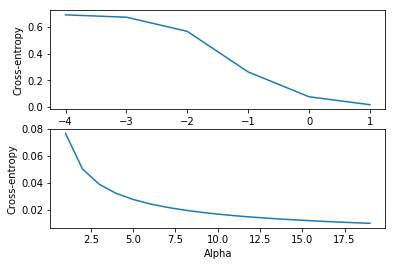

In [6]:
# Parameters
path_train_data = 'dataset/classification/cl_train_1.csv'
path_test_data = 'dataset/classification/cl_test_1.csv'
initial_weights = [0, 0, 0]
iterations = 1000
feature_name = ['x0', 'x1', 'x2']

# Plot performance with different learning rates
train_score_range1 = []
train_score_range2 = []

# check the model performance for alpha on training data (using powers of 10)
for a in range(-4, 2):
    w_train, e_train = train(path_train_data, initial_weights, feature_name, math.pow(10,a), iterations)
    train_score_range1.append(e_train[-1])

# using a different range
for a in range(1, 20):
    w_train, e_train = train(path_train_data, initial_weights, feature_name, a, iterations)
    train_score_range2.append(e_train[-1])
    
fig, (ax1, ax2) = plt.subplots(2,1)
ax1.plot(range(-4,2), train_score_range1)
ax2.plot(range(1,20), train_score_range2)
ax1.set(xlabel='Alpha', ylabel='Cross-entropy')
ax2.set(xlabel='Alpha', ylabel='Cross-entropy')
plt.show()

We can see that the performance is best with rather high learning rates. I will use alpha = 5 here.

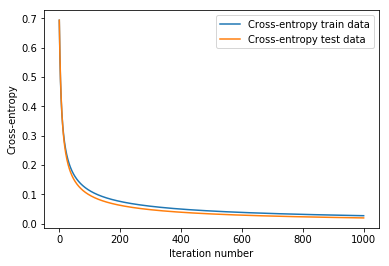

Cross-entropy error training data: 0.02780647804921424
Cross-entropy error test data: 0.020269393422011946


Prediction accuracy: 1.0


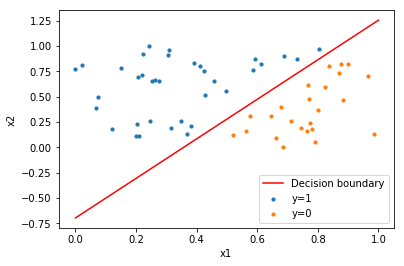

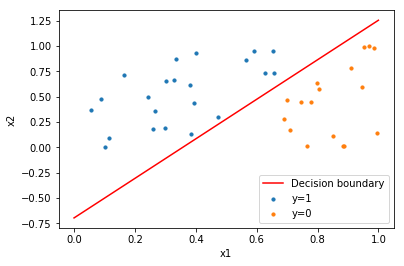

In [7]:
alpha = 5

# Train weights 
trained_weights_train_data, cross_entropy_train_data = train(path_train_data, initial_weights, 
                                                             feature_name, alpha, iterations)
trained_weights_test_data, cross_entropy_test_data = train(path_test_data, initial_weights, 
                                                           feature_name, alpha, iterations)

# Plot cross-entropy
plot_cross_entropy(cross_entropy_train_data, cross_entropy_test_data, iterations)
print("Cross-entropy error training data:",cross_entropy_train_data[-1])
print("Cross-entropy error test data:",cross_entropy_test_data[-1])
print('\n')

# Test precision
accuracy = test(path_test_data, trained_weights_train_data, feature_name)
print("Prediction accuracy:", accuracy)

# Plot decision boundary
plot_linear_decision_boundary(path_train_data, trained_weights_train_data, iterations)
plot_linear_decision_boundary(path_test_data, trained_weights_train_data, iterations)

## Task 5

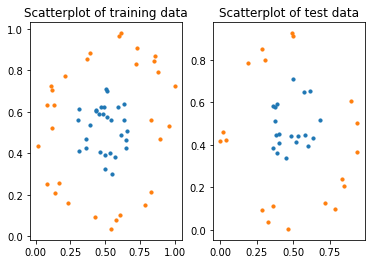

In [8]:
path_train_data = 'dataset/classification/cl_train_2.csv'
path_test_data = 'dataset/classification/cl_test_2.csv'

df = load_csv(path_train_data)
admitted = df.loc[df['y'] == 1]
not_admitted = df.loc[df['y'] == 0]

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.scatter(admitted.iloc[:, 0], admitted.iloc[:, 1], s=10, label='y=1')
ax1.scatter(not_admitted.iloc[:, 0], not_admitted.iloc[:, 1], s=10, label='y=0')
ax1.set_title('Scatterplot of training data')

df = load_csv(path_test_data)
admitted = df.loc[df['y'] == 1]
not_admitted = df.loc[df['y'] == 0]

ax2.scatter(admitted.iloc[:, 0], admitted.iloc[:, 1], s=10, label='y=1')
ax2.scatter(not_admitted.iloc[:, 0], not_admitted.iloc[:, 1], s=10, label='y=0')
ax2.set_title('Scatterplot of test data')
plt.show()

As we can see, the data is not linearly separable. To be able to correctly classify the dataset with logistic regression, we need to add quadratic features to be able to separate the data.

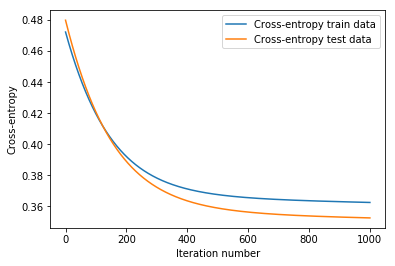

Accuracy: 1.0


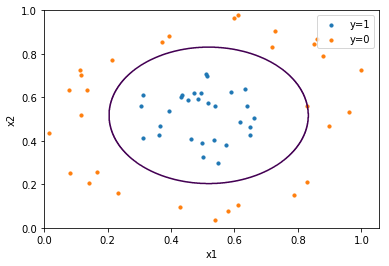

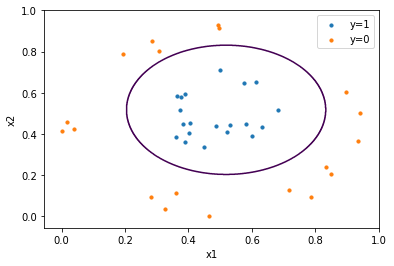

[-4.284107098364902, 10.30209926663444, 10.35045906916575, -9.961908346961593, -9.921545427423887]


In [10]:
# Parameters
initial_weights = [-5, 10, 10, -10, -10]
alpha = 0.01
iterations = 1000
feature_name = ['x0', 'x1', 'x2', 'x1^2', 'x2^2']

# Train weights
trained_weights_train_data, cross_entropy_train_data = train(path_train_data, initial_weights, 
                                                             feature_name, alpha, iterations)
trained_weights_test_data, cross_entropy_test_data = train(path_test_data, initial_weights, 
                                                           feature_name, alpha, iterations)

# Plot cross-entropy
plot_cross_entropy(cross_entropy_train_data, cross_entropy_test_data, iterations)

# Test precision
accuracy = test(path_test_data, trained_weights_train_data, feature_name)
print("Accuracy:", accuracy)

# Plot decision boundary
plot_radial_decision_boundary(path_train_data, trained_weights_train_data, iterations)
plot_radial_decision_boundary(path_test_data, trained_weights_train_data, iterations)
print(trained_weights_test_data)